In [55]:
from utils.preprocess import set_b_dataset
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
import librosa
import librosa.display
from torch.utils.data import Dataset

PROJECT_DIR = '/Users/nattapolchanpaisit/Documents/GitHub/Algorithm/SC1015-PROJECT/'
data_a_path = pd.read_csv(f'{PROJECT_DIR}dataset/set_a.csv')
data_b_path = pd.read_csv(f'{PROJECT_DIR}dataset/set_b.csv')
data_a_timing = pd.read_csv(f'{PROJECT_DIR}dataset/set_a_timing.csv')


dataset = set_b_dataset(PROJECT_DIR)

/Users/nattapolchanpaisit/miniforge3/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  return f(*args, **kwargs)


## Exploratory data analysis

(0.0, 2500.0)

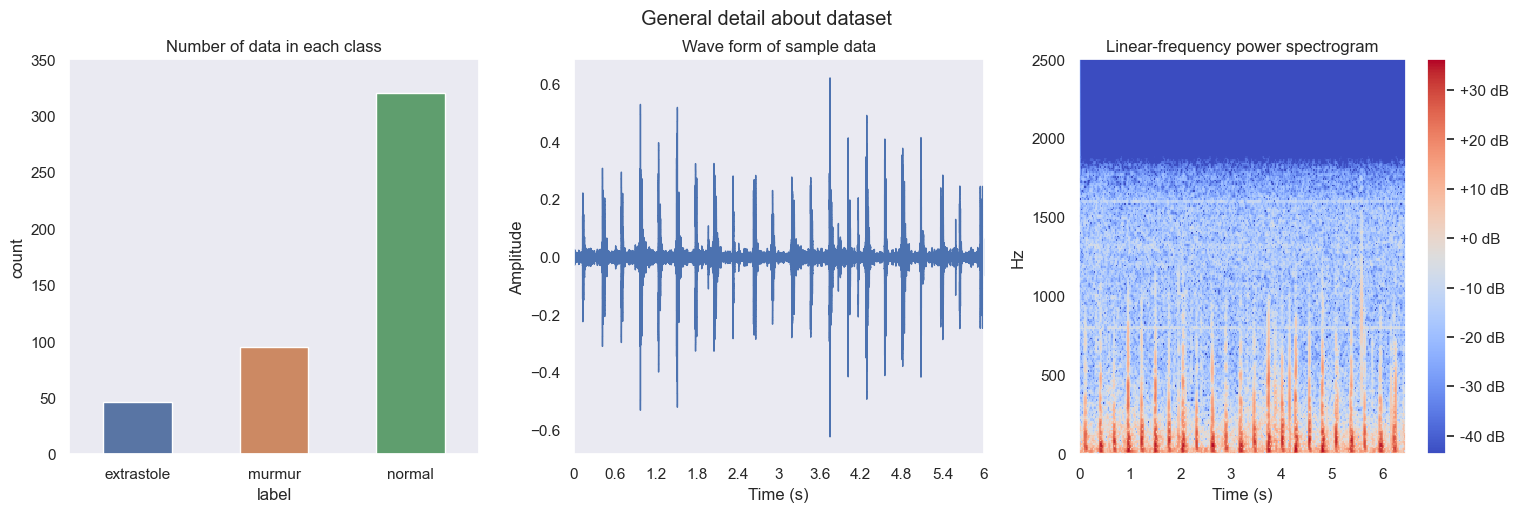

In [75]:
fig, axes = plt.subplots(1,3, figsize=(15,5))
fig.tight_layout(w_pad=3.0)
fig.suptitle('General detail about dataset')
sb.set_theme(style="dark")
plt.subplots_adjust(top=0.88)
sb.countplot(data_b_path, ax=axes[0], x='label', width=0.5)
axes[0].set_title('Number of data in each class')
axes[0].set_ylim([0, 350])

dataset.show_wave(10, ax=axes[1])
axes[1].set_ylabel('Amplitude')
axes[1].set_xlabel('Time (s)')
axes[1].set_xlim([0, 6])
axes[1].set_title('Wave form of sample data')

spectrogram = dataset.show_spec(10, ax=axes[2], y_axis='linear', x_axis='time')
fig.colorbar(spectrogram, format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')
axes[2].set_xlabel('Time (s)')
axes[2].set_ylim([0, 2500])